In [1]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


In [2]:
if device == "cuda":
    print(f"Device: {torch.cuda.get_device_name()}.")

Device: NVIDIA GeForce RTX 4090.


### Importing MIDI

music21 can be used to open, manipulate, play and save MIDI files.

In [3]:
from pathlib import Path
import music21 as m21

musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)

midi_file = Path('data/midi/Mana_GB_Final Fantasy Adventure_Battle 2.mid')
final_fantasy_midi = m21.midi.MidiFile()
final_fantasy_midi.open(midi_file)
final_fantasy_midi.read()
final_fantasy_midi.close()

final_fantasy_midi

<music21.midi.MidiFile 2 tracks>

If we convert the MIDI file into a music21 stream we can play it back OK

In [4]:
final_fantasy_m21stream = m21.midi.translate.midiFileToStream(final_fantasy_midi)
final_fantasy_m21stream.show('midi')

We can get the bytes of a single track

In [5]:
final_fantasy_midi_trk_0 = final_fantasy_midi.tracks[0]
final_fantasy_midi_trk_0.getBytes()

b'MTrk\x00\x00\x00\xd5\x00\xffT\x05`\x00\x00\x00\x00\x00\xffX\x04\x04\x02\x18\x08\x00\xffY\x02\x02\x00\x00\xffQ\x03\x06\x1a\x80\x00\xffQ\x03\x06\x1a\x80\x00\xffQ\x03\x06\x1a\x80\xa0\x00\xffQ\x03\x06\x1a\x80\x81\xb0\x00\xffQ\x03\x06\x1a\x80\x82\x00\xffQ\x03\x06%\x92\x82\x00\xffQ\x03\x060*\x82\x00\xffQ\x03\x0652\x82\x00\xffQ\x03\x06@\x00\x82\x00\xffQ\x03\x06E\xc8\x82\x00\xffQ\x03\x06P\xd1\x82\x00\xffQ\x03\x06V\x11\x84\x00\xffQ\x03\x06\x1a\x80\x84\xfe\x00\xffQ\x03\x06\x1a\x80\x81\xb0\x00\xffQ\x03\x06\x1a\x80\x82\x00\xffQ\x03\x06%\x92\x82\x00\xffQ\x03\x060*\x82\x00\xffQ\x03\x0652\x82\x00\xffQ\x03\x06@\x00\x82\x00\xffQ\x03\x06E\xc8\x82\x00\xffQ\x03\x06P\xd1\x82\x00\xffQ\x03\x06V\x11\x84\x00\xffQ\x03\x06\x1a\x80\x84\xfd\x7f\xff/\x00'

However, if we try playing a single track stream it goes to shit because the timing info is in the parent track stream. I was a bit surprised as the merged track has all the tempo track info but ah well.

In [6]:
final_fantasy_m21stream_trk_0 = m21.midi.translate.midiTrackToStream(final_fantasy_midi_trk_0)
final_fantasy_m21stream_trk_0.show('midi')

It's looking like encoding the raw MIDI might be tricky, although something in my gut tells me it is the right way, or at least there is some insight to be had.

I think the best way forward is to pull in the basics from musicautobot and try to understand them. No point in running before we walk and all that.

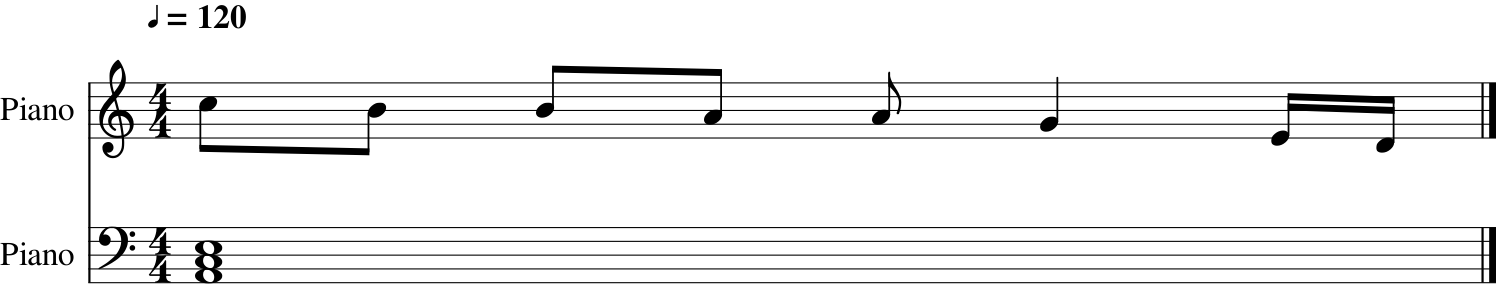

In [7]:
single_bar_path = Path('data/midi/single_bar_example.mid')

single_bar_midi_file = m21.midi.MidiFile()
single_bar_midi_file.open(single_bar_path)
single_bar_midi_file.read()
single_bar_midi_file.close()

single_bar_m21stream = m21.midi.translate.midiFileToStream(single_bar_midi_file)
single_bar_m21stream.show()

The offset in the left column is in 'quarter bars'

In [8]:
single_bar_m21stream.show('text')

{0.0} <music21.stream.Part 0x7f70caebc9d0>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Piano 'Piano: Piano'>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.tempo.MetronomeMark animato Quarter=120>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Note C>
        {0.5} <music21.note.Note B>
        {1.0} <music21.note.Note B>
        {1.5} <music21.note.Note A>
        {2.0} <music21.note.Note A>
        {2.5} <music21.note.Note G>
        {3.5} <music21.note.Note E>
        {3.75} <music21.note.Note D>
        {4.0} <music21.bar.Barline type=final>
{0.0} <music21.stream.Part 0x7f70cadfe470>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Piano 'Piano: Piano'>
        {0.0} <music21.clef.BassClef>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.chord.Chord A2 C3 E3>
        {4.0} <music21.bar.Barline type=final>


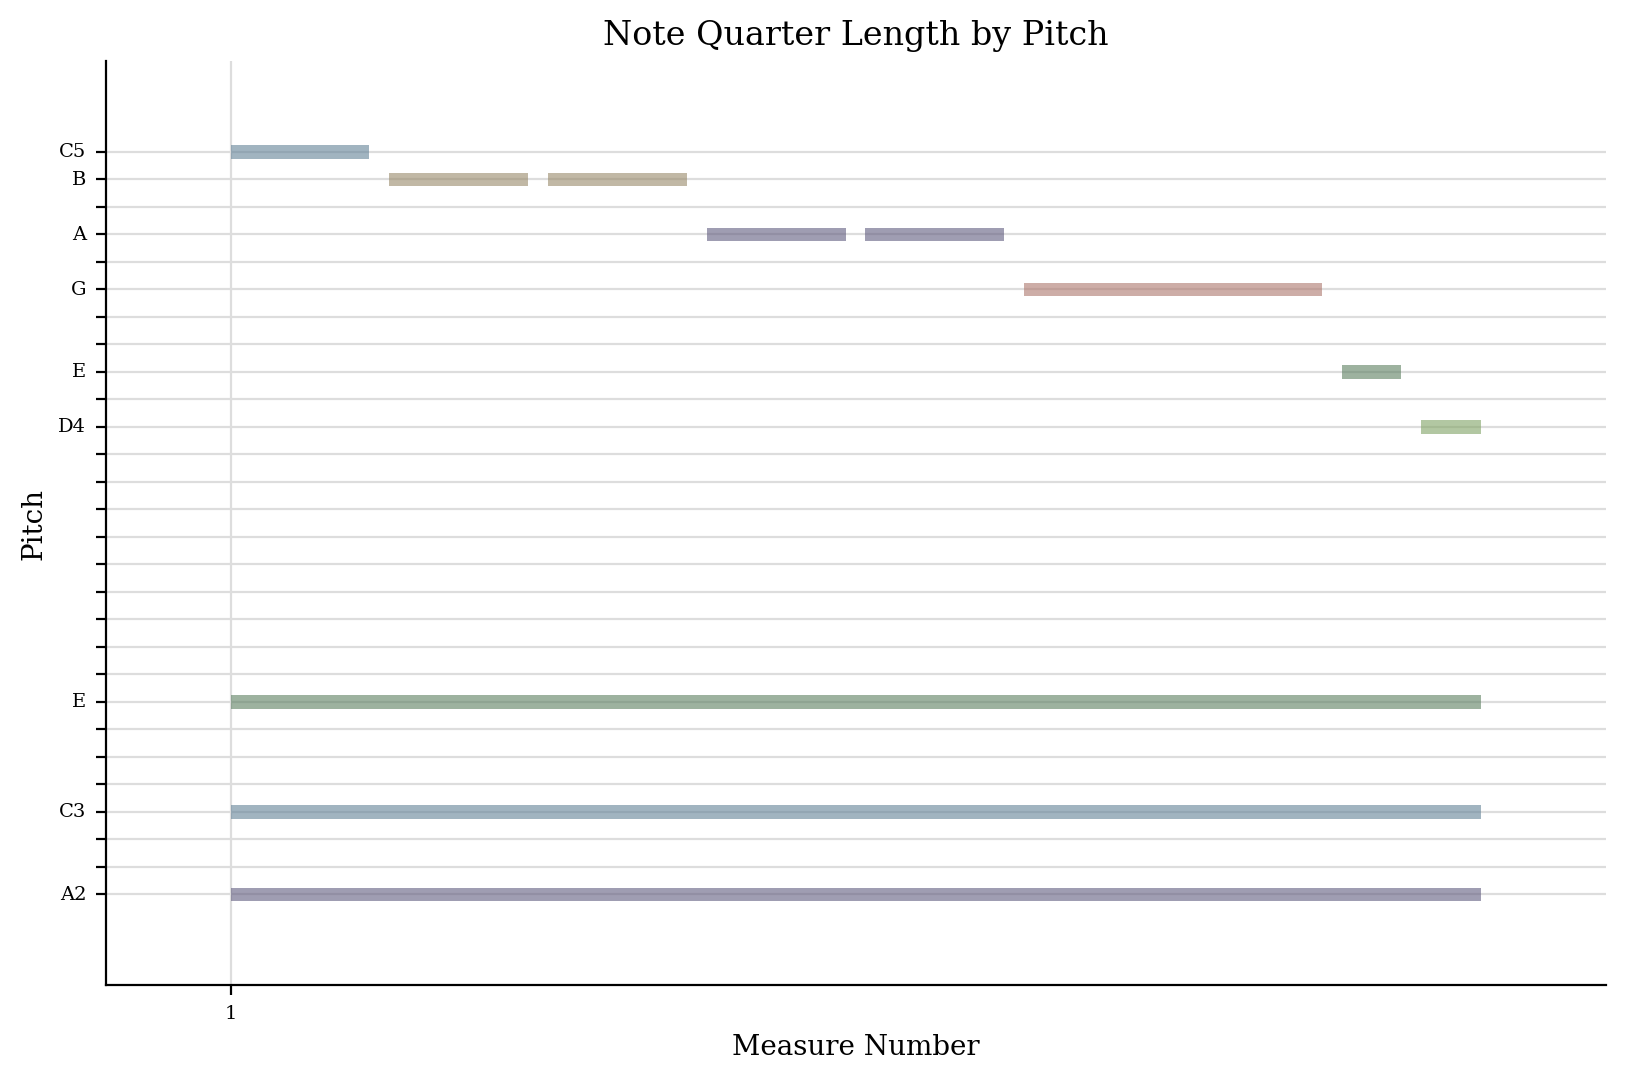

In [9]:
single_bar_m21stream.plot()

### One Hot Encoding

Code to convert a music21 stream into a psuedo one-hot encoded score taken from musicautobot's `numpy_encode` module.

In [10]:
import numpy as np
from itertools import chain

BPB = 4 # beats per bar
VALTCONT = -2 # numpy value for TCONT - needed for compressing chord array
SAMPLE_FREQ = 4 # number of samples per quarter, i.e. 4 beats per bar and 4 samples per beat gives 16 samples per bar
NOTE_SIZE = 128
MAX_NOTE_DUR = (8*BPB*SAMPLE_FREQ)

def m21stream_to_sparse_enc(m21stream_score, note_size=NOTE_SIZE, sample_freq=SAMPLE_FREQ, max_note_dur=MAX_NOTE_DUR):
    "Converts music21.Stream to 1-hot numpy array"
    
    # Time is measured in quarter notes since the start of the piece
    # Original states that we are assuming 4/4 time but I don't see why that would be the case. BPB isn't used here.

    # (Author) TODO: need to order by instruments most played and filter out percussion or include the channel
    highest_time = max(
        m21stream_score.flatten().getElementsByClass('Note').stream().highestTime,
        m21stream_score.flatten().getElementsByClass('Chord').stream().highestTime)
    
    # Calculate the maximum number of time steps
    max_timestep = round(highest_time * sample_freq)+1

    # Array to hold the one hot encoding of the score
    sparse_score = np.zeros((max_timestep, len(m21stream_score.parts), note_size))

    # Convert a note to a tuple of (pitch,offset,duration)
    def note_data(pitch, note):
        return (pitch.midi, int(round(note.offset*sample_freq)), int(round(note.duration.quarterLength*sample_freq)))

    for idx,part in enumerate(m21stream_score.parts):
        
        notes = chain.from_iterable(
            [note_data(elem.pitch, elem)] if isinstance(elem, m21.note.Note)
            else [note_data(p, elem) for p in elem.pitches] if isinstance(elem, m21.chord.Chord) 
            else []
            for elem in part.flatten()
        )

        # sort flattened note list by offset (1), duration (2) so that hits are not overwritten and longer notes have priority
        notes_sorted = sorted(notes, key=lambda x: (x[1], x[2])) 

        for n in notes_sorted:
            
            if n is None: continue

            pitch,offset,duration = n # Unpack the note tuple
            clamped_duration = max_note_dur if max_note_dur is not None and duration > max_note_dur else duration

            # Set the first active position for the note in the 'one hot encoded' score to duration value (also used when decoding)
            sparse_score[offset, idx, pitch] = clamped_duration

            # Continue holding the note for the duration, set to a contant value of -2
            sparse_score[offset+1:offset+clamped_duration, idx, pitch] = VALTCONT # Continue holding note
    
    return sparse_score

In [11]:
sparse_score = m21stream_to_sparse_enc(single_bar_m21stream); 
sparse_score.shape

(17, 2, 128)

In [12]:
timestep_1 = sparse_score[1].nonzero(); 
timestep_1

(array([0, 1, 1, 1]), array([72, 45, 48, 52]))

Channel 1 holds the 3 note chord in the lower register at positions 45, 48, 52

The value for these notes at the first time position is their length in beats

In [13]:
sparse_score[0, 1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0., 16.,  0.,  0.,  0.,
       16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

As these are held, following time positions are padded with a constant -2 (`VALTCONT`)

In [14]:
sparse_score[1, 1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0., -2.,  0.,  0.,  0.,
       -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [15]:
sparse_score[2, 1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0., -2.,  0.,  0.,  0.,
       -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

Channel 0 holds the upper melody part, starting with note 72 for two beats

In [16]:
sparse_score[0, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
sparse_score[1, 0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

Then note 71 and so on

In [18]:
sparse_score[2, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

This is why non-zero gives us the active columns and makes it act one hot, even though numbers aren't clamped to 0 or 1.



### Dense Encoding

Sparse one-hot encoding is too inefficient, so we want to just encode what notes play and for how long.

musicbot does this like so:

In [19]:
from functools import reduce

VALTSEP = -1 # separator value for numpy encoding
PIANO_RANGE = (21, 108)

# Pass in the 'one-hot' encoded numpy score
def sparse_score_to_note_position_enc(sparse_score, skip_last_rest=True):

    def encode_timestep(acc, timestep):
        encoded_timesteps, wait_count = acc
        encoded_timestep = timestep_to_note_position_enc(timestep) # pass in all notes for both instruments, merged list returned
        if len(encoded_timestep) == 0: # i.e. all zeroes at time step
            wait_count += 1
        else:
            if wait_count > 0: 
                encoded_timesteps.append([VALTSEP, wait_count])
            encoded_timesteps.extend(encoded_timestep)
            wait_count = 1
        return encoded_timesteps, wait_count
    
    encoded_timesteps, final_wait_count = reduce(encode_timestep, sparse_score, ([], 0))

    if final_wait_count > 0 and not skip_last_rest:
        encoded_timesteps.append([VALTSEP, final_wait_count]) # add trailing rests

    return np.array(encoded_timesteps, dtype=int).reshape(-1, 2) # reshaping. Just in case result is empty
    
def timestep_to_note_position_enc(timestep, note_range=PIANO_RANGE, enc_type=None):

    note_min, note_max = note_range

    def encode_note_data(note_data, active_note_idx):
        instrument,note = active_note_idx
        duration = timestep[instrument, note]
        if duration != VALTCONT and note >= note_min and note < note_max: 
            note_data.append([note, duration, instrument])
        return note_data
    
    encoded_notes = reduce(encode_note_data, zip(*timestep.nonzero()), [])
    sorted_notes = sorted(encoded_notes, key=lambda x: x[0], reverse=True) # sort by note (highest to lowest)
    
    match enc_type:
        case None: 
            # pitch, duration
            return [n[:2] for n in sorted_notes] 
        case 'parts':
            # pitch, duration, instrument
            return sorted_notes
        case 'full':
            # note_class, duration, octave, instrument
            return [[n%12, d, n//12, i] for n,d,i in sorted_notes]

This considerably reduces the size of the score.

In [20]:
note_position_score = sparse_score_to_note_position_enc(sparse_score)
note_position_score.shape

(18, 2)

In [21]:
f'Sparse encoding size: {np.prod(sparse_score.shape)}', f'Note encoding size: {np.prod(note_position_score.shape)}'

('Sparse encoding size: 4352', 'Note encoding size: 36')

Each row is a note on in the form of a pitch and a duration.

Notes can be 1-128, duration can be 1-256.

-1 is the rest / wait value

In [22]:
note_position_score

array([[72,  2],
       [52, 16],
       [48, 16],
       [45, 16],
       [-1,  2],
       [71,  2],
       [-1,  2],
       [71,  2],
       [-1,  2],
       [69,  2],
       [-1,  2],
       [69,  2],
       [-1,  2],
       [67,  4],
       [-1,  4],
       [64,  1],
       [-1,  1],
       [62,  1]])

### Vocab

Next we want to convert the raw note values into their vocab indexes, along with any special tokens we need to mark up our stream.

We also want to flatten into a 1D tensor e.g.

In [23]:
np.array([
    [1,2], 
    [3,4], 
    [5,6]]).reshape(-1)

array([1, 2, 3, 4, 5, 6])

In [24]:
BOS = 'xxbos'
PAD = 'xxpad'
EOS = 'xxeos'
SEP = 'xxsep' # Used to denote end of timestep (required for polyphony). Note int -1

 # SEP token must be last, i.e. one place before note tokens, so that adding the note offset still works when encoding
SPECIAL_TOKS = [BOS, PAD, EOS, SEP]

NOTE_SIZE = 128
NOTE_TOKS = [f'n{i}' for i in range(NOTE_SIZE)]

DUR_SIZE = 8 * BPB * SAMPLE_FREQ + 1 # 8 bars of sixteenth (semiquaver) notes + 1 for 0 length
DUR_TOKS = [f'd{i}' for i in range(DUR_SIZE)]

NOTE_START, NOTE_END = NOTE_TOKS[0], NOTE_TOKS[-1]
DUR_START, DUR_END = DUR_TOKS[0], DUR_TOKS[-1]

ALL_TOKS = SPECIAL_TOKS + NOTE_TOKS + DUR_TOKS

ALL_TOKS[0:8]

['xxbos', 'xxpad', 'xxeos', 'xxsep', 'n0', 'n1', 'n2', 'n3']

In [25]:
from typing import Collection, List

class MusicVocab():
    def __init__(self):
        itos = SPECIAL_TOKS + NOTE_TOKS + DUR_TOKS
        # Ensure that the vocab is a multiple of 8 for fp16 training
        if len(itos)%8 != 0:
            itos = itos + [f'dummy{i}' for i in range(len(itos)%8)]
        self.itos = itos
        self.stoi = {v:k for k,v in enumerate(self.itos)}

    def to_indices(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their indices."
        return [self.stoi[w] for w in t]

    def to_tokens(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of indices to their tokens."
        items = [self.itos[i] for i in nums]
        return sep.join(items) if sep is not None else items

    @property
    def pad_idx(self): return self.stoi[PAD]
    @property
    def bos_idx(self): return self.stoi[BOS]
    @property
    def eos_idx(self): return self.stoi[EOS]
    @property
    def sep_idx(self): return self.stoi[SEP]
    @property
    def note_range(self): return self.stoi[NOTE_START], self.stoi[NOTE_END]+1
    @property
    def dur_range(self): return self.stoi[DUR_START], self.stoi[DUR_END]+1

As it stands this is like character-level encoding for text. 

We haven't chunked tokens by training on example data. We simply have a single dedicated token for each note, duration and special token.

Perhaps we would have commonly lots of spaces up to a bar, so separators would have 2..8 chunk versions (e.g. 'xxsep xxsep xxsep' etc). That would save long gaps using up context width ala GPT grouping spaces to make code easier to parse.

### Converting to indices

Now that we have our indexed vocabulary, we can flatten our note / duration pairs into a single list, and map it into vocab indices (or text).

In [26]:
from enum import Enum

SEQType = Enum('SEQType', 'Sentence, Empty')

def note_position_to_idx_enc(note_position_score, vocab, seq_type=SEQType.Sentence, add_eos=False):
    note_idx_score = note_position_score.copy()
    note_min_idx, _ = vocab.note_range
    dur_min_idx, _ = vocab.dur_range
    # Replace note and duration tokens with their index in vocab. 
    # Tokens are the same order as notes and note_min_idx offset is constant so we can apply in one go.
    # Using broadcasting to add the 1D [note_min_idx, dur_min_idx] to the 2D note_idx_score.
    note_idx_score += np.array([note_min_idx, dur_min_idx])
    prefix = np.empty(0, dtype=int) if seq_type == SEQType.Empty else np.array([vocab.bos_idx, vocab.pad_idx])
    suffix = np.array([vocab.stoi[EOS]]) if add_eos else np.empty(0, dtype=int)
    return np.concatenate([prefix, note_idx_score.reshape(-1), suffix])

In [27]:
vocab = MusicVocab()
idx_score = note_position_to_idx_enc(note_position_score, vocab, add_eos=True)
idx_score

array([  0,   1,  76, 134,  56, 148,  52, 148,  49, 148,   3, 134,  75,
       134,   3, 134,  75, 134,   3, 134,  73, 134,   3, 134,  73, 134,
         3, 134,  71, 136,   3, 136,  68, 133,   3, 133,  66, 133,   2])

In [28]:
vocab.to_tokens(idx_score)

'xxbos xxpad n72 d2 n52 d16 n48 d16 n45 d16 xxsep d2 n71 d2 xxsep d2 n71 d2 xxsep d2 n69 d2 xxsep d2 n69 d2 xxsep d2 n67 d4 xxsep d4 n64 d1 xxsep d1 n62 d1 xxeos'